# Домашнее задание

### ИАД. 2024-2025

### Прогнозирование временных рядов

Мы постарались составить домашнее задание так, чтобы оно помогло закрепить все то, что мы прошли за 2 недели на лекциях и семинарах. Вы вольны использовать любые библиотеки, которые вам нравятся. Главное — это осознанность в выборе методов и интерпретации выводов.

В рамках домашнего задания будем работать с датасетом `NN5`, который можно скачать [здесь](https://zenodo.org/records/4656117). Временные ряды в этом датасете представляют собой данные по ежедневным снятиям наличных в банкоматах в Великобритании.

### Задание 1. Первичный анализ данных (1 балл)

In [3]:
!pip install statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 14.1 MB/s eta 0:00:00


In [4]:
import logging

logger = logging.getLogger(__name__)
import sys

c_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(c_handler)
logging.basicConfig(level=logging.INFO, force=True)

import random
import warnings
from datetime import datetime
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from statsforecast import StatsForecast, models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

warnings.filterwarnings("ignore")

In [5]:
def mase(
    forecast: np.ndarray,
    insample: np.ndarray,
    outsample: np.ndarray,
    frequency: int,
) -> np.ndarray:
    """MASE loss as defined in "Scaled Errors" https://robjhyndman.com/papers/mase.pdf

    Args:
        forecast: Forecast values. Shape: batch, time_o
        insample: Insample values. Shape: batch, time_i
        outsample: Target values. Shape: batch, time_o
        frequency: Frequency value
    Returns:
        Same shape array with error calculated for each time step
    """
    return np.mean(np.abs(forecast - outsample)) / np.mean(
        np.abs(insample[:-frequency] - insample[frequency:])
    )

Нам пригодятся уже знакомые функции с семинаров по чтению рядов в формате tsf. Напомню, что иногда временные ряды могут быть представлены в tsf формате. Это такая структура данных, которая позволяет хранить метаинформацию о временных рядах, а также пары "первая дата — все значения временного ряда".

Функции позволяют считать данные в tsf формате и перевести их в формат, которым мы можем пользоваться.

In [6]:
def convert_tsf_to_dataframe(
    full_file_path_and_name: str,
    replace_missing_vals_with: Any = "NaN",
    value_column_name: str = "series_value",
) -> tuple[pd.DataFrame, str, int, str, str]:
    """
    Конвертирует файл формата TSF в pandas DataFrame.

    Args:
        full_file_path_and_name: Путь к файлу формата TSF.
        replace_missing_vals_with: Значение для замены пропусков.
        value_column_name: Имя столбца для значений временных рядов.

    Returns:
        DataFrame с данными временных рядов.
        Частота данных.
        Прогнозируемый горизонт.
        Содержат ли данные пропуски.
        Равны ли длины временных рядов.

    """
    col_names = []
    col_types = []
    all_data = {}
    all_series = []
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    data_started = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            if line.startswith("@"):
                if line.startswith("@data"):
                    data_started = True
                    # Инициализируем словарь для данных атрибутов
                    for col in col_names:
                        all_data[col] = []
                else:
                    parts = line.split(" ")
                    if line.startswith("@attribute"):
                        col_names.append(parts[1])
                        col_types.append(parts[2])
                    elif line.startswith("@frequency"):
                        frequency = parts[1]
                    elif line.startswith("@horizon"):
                        forecast_horizon = int(parts[1])
                    elif line.startswith("@missing"):
                        contain_missing_values = parts[1].lower() in (
                            "y",
                            "yes",
                            "t",
                            "true",
                            "on",
                            "1",
                        )
                    elif line.startswith("@equallength"):
                        contain_equal_length = parts[1].lower() in (
                            "y",
                            "yes",
                            "t",
                            "true",
                            "on",
                            "1",
                        )
            elif not line.startswith("#") and data_started:
                parts = line.split(":")
                # Последняя часть содержит значения ряда
                series_vals = parts[-1].split(",")
                numeric_series = [
                    replace_missing_vals_with if val == "?" else float(val) for val in series_vals
                ]
                all_series.append(pd.Series(numeric_series).array)
                # Преобразуем и сохраняем значения атрибутов
                for i in range(len(col_names)):
                    if col_types[i] == "numeric":
                        all_data[col_names[i]].append(int(parts[i]))
                    elif col_types[i] == "string":
                        all_data[col_names[i]].append(parts[i])
                    elif col_types[i] == "date":
                        all_data[col_names[i]].append(
                            datetime.strptime(parts[i], "%Y-%m-%d %H-%M-%S")
                        )

    all_data[value_column_name] = all_series
    loaded_data = pd.DataFrame(all_data)
    return loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length


def date_to_daterange(x: pd.Series, freq: str) -> pd.Series:
    """
    Преобразует временные метки в диапазон дат.

    Args:
        x: Временные метки.
        freq: Частота.

    Returns:
        pd.Series с диапазоном дат.

    """
    return pd.Series(pd.date_range(start=x.iloc[0], periods=len(x), freq=freq))


def convert_tsf_to_multivariate_or_standard_format(
    tsf_data_path: str,
    target_column: str = "series_value",
    date_from_column: str = "start_timestamp",
    id_column: str = "series_name",
    # one from ["multivariate", "standard"]
    format: str = "multivariate",
) -> pd.DataFrame:
    """
    Преобразует данные формата TSF в формат pandas DataFrame:
        если format == "standard" -> датафрейм с колонками "id", "date" и "value"
        если format == "multivariate" -> pivot таблица c date в качестве индекса,
            id в качестве колонок и значениями из value_column_name

    Args:
        tsf_data_path: Путь к файлу формата TSF.
        target_column: Имя столбца с целевой переменной.
        date_from_column: Имя столбца с переменной дат.
        id_column: Имя столбца с идентификаторами временных рядов.
        format: Формат данных ("multivariate" или "standard").

    Returns:
        pd.DataFrame с данными в формате "id", "date" и "value".

    """
    FREQ_MAP = {
        "monthly": "MS",
        "10_minutes": "10min",
        "half_hourly": "30min",
        "minutely": "1min",
        "daily": "D",
        "weekly": "7D",
        "yearly": "YS",
        "quarterly": "QS",
        "hourly": "H",
    }

    tsf_df, freq = convert_tsf_to_dataframe(tsf_data_path)[:2]

    # Преобразуем списки в {target_column} в "длинный столбец" со значениями
    tsf_df = tsf_df.explode(target_column)
    # Заменим повторяющиеся значения даты в {date_column} на date_range
    tsf_df["date"] = (
        tsf_df.groupby(id_column, sort=False)[date_from_column]
        .apply(lambda x: date_to_daterange(x, FREQ_MAP[freq]))
        .values
    )
    tsf_df = tsf_df.drop(columns=date_from_column)
    # Переименуем колонки
    tsf_df = tsf_df.rename(columns={id_column: "id", target_column: "value"}).reset_index(
        drop=True
    )
    # Приведем {id_column} к численным значениям
    ids2num = dict(zip(tsf_df["id"].unique(), np.arange(tsf_df["id"].nunique())))
    tsf_df["id"] = tsf_df["id"].map(ids2num)

    if format == "standard":
        return tsf_df
    return pd.pivot_table(tsf_df, values="value", index="date", columns="id")

#### Задание 1.1: Загрузка данных (0 баллов)

Давайте скачаем датасет __NN5__ и загрузим его, воспользовавшись функцией `convert_tsf_to_multivariate_or_standard_format`.

In [7]:
!wget "https://zenodo.org/records/4656117/files/nn5_daily_dataset_without_missing_values.zip?download=1" -O nn5_daily_dataset_without_missing_values.zip
!unzip -o nn5_daily_dataset_without_missing_values.zip
!rm nn5_daily_dataset_without_missing_values.zip

--2025-05-23 17:22:07--  https://zenodo.org/records/4656117/files/nn5_daily_dataset_without_missing_values.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289779 (283K) [application/octet-stream]
Saving to: ‘nn5_daily_dataset_without_missing_values.zip’

nn5_daily_dataset_w 100%[===================>] 282.99K   159KB/s    in 1.8s    

2025-05-23 17:22:10 (159 KB/s) - ‘nn5_daily_dataset_without_missing_values.zip’ saved [289779/289779]

Archive:  nn5_daily_dataset_without_missing_values.zip
  inflating: nn5_daily_dataset_without_missing_values.tsf  


In [8]:
df = convert_tsf_to_multivariate_or_standard_format(
    "nn5_daily_dataset_without_missing_values.tsf", format="standard"
)
df.head()

id      value       date
0   0  13.407029 1996-03-18
1   0  14.725057 1996-03-19
2   0  20.564059 1996-03-20
3   0   34.70805 1996-03-21
4   0  26.629819 1996-03-22

#### Задание 1.2: Типы данных (0.3 балла)

Выведите типы данных в датасете. Проверьте, что они корректные: даты должны быть в формате datetime, id — object, а значения временных рядов — float. Если это не так, то исправьте их.

In [9]:
df.dtypes

id                int64
value            object
date     datetime64[ns]
dtype: object

Не корректны, преобразуем

In [10]:
df['id']=df['id'].astype(object)
df['value']=df['value'].astype(float)
df.dtypes

id               object
value           float64
date     datetime64[ns]
dtype: object

#### Задание 1.3: Пропуски (0.05 балла)

Проверьте, есть ли в данных пропуски. Если они есть, то заполните их предыдущими значениями. Если пропусков нет, то просто выведите сообщение об этом.

In [11]:
df.isna().sum().sum()

np.int64(0)

#### Задание 1.4: Визуальный анализ временных рядов (0.4 балла)

Постройте линейные графики временных рядов. По оси X отложите время, по оси Y — значения временного ряда.

Используйте Plotly, чтобы можно было отложить сразу все временные ряды на одном графике.

In [10]:
import plotly.express as px

fig = px.line(df,
              x='date',
              y='value',
              color='id',
              title='Временные ряды по разным id',
              labels={'value': 'Значение', 'date': 'Дата', 'id': 'ID ряда'})

fig.update_layout(
    hovermode='x unified',
    legend_title_text='ID ряда',
    plot_bgcolor='white',
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

fig.show()

In [11]:
time_diffs = df['date'].diff().dropna()
time_diffs.unique()

<TimedeltaArray>
['1 days', '-790 days']
Length: 2, dtype: timedelta64[ns]

In [12]:
for id_val in df['id'].unique():
    print(f"ID {id_val}: min={df[df['id'] == id_val]['date'].min()}, max={df[df['id'] == id_val]['date'].max()}")

ID 0: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID 1: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID 2: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID 3: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID 4: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID 5: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID 6: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID 7: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID 8: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID 9: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID 10: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID 11: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID 12: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID 13: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID 14: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID 15: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID 16: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID 17: min=1996-03-18 00:00:00, max=1998-05-17 00:00:00
ID

__Ответьте на следующие вопросы:__
- Какова частотность (frequency) данных? ежедневные
- Выровнены ли временные ряды? да, тк все ряды начинаются и заканчиваются в одно время
- Стационарны ли временные ряды? Если нет, то какие признаки нестационарности вы можете выделить? на одном графике тяжело рассмотреть все, но скорее всего большинство из них не стационарны, где то видны тренд и сезонность, дисперсия изменяется
- На какие группы можно разбить временные ряды по наличию общих признаков? Есть ли что-то, чем похожи все временные ряды?
можно разбить по значениям (выше среднего/ниже среднего по всем рядам), тренду (восходящий/нисходящий/без тренда), по наличию и преиоду сезонности
общее - один период времени и большинство имеют сезонные колебания
- Есть ли в рядах выбросы? Как вы можете это определить?
визуально есть, можно найти по правилам iqr/std

#### Задание 1.5: Выделение тестовой выборки (0.25 балла)

Выделите 10% данных для теста, а остальные 90% оставьте для обучения. Делайте это очень аккуратно, чтобы не нарушить временную и многомерную структуру данных!

Вспомните и напишите, в чем особенность выделения тестовой выборки в задаче прогнозирования временных рядов и в задаче прогнозирования __многомерных__ временных рядов.

Обратите внимание, что временные ряды выровнены, а значит, в отличие от семинара, пробегаться в цикле по каждому id не нужно. Подумайте, как можно сделать это более эффективно.

In [8]:
test_size = 0.1
HORIZON = int(len(df['date'].unique()) * test_size)  # rол-во точек для теста

unique_dates = np.sort(df['date'].unique())
split_date = unique_dates[-HORIZON]  # пороговая дата

train_data = df[df['date'] < split_date]
test_data = df[df['date'] >= split_date]

print(f"Train dates: {train_data['date'].min()} — {train_data['date'].max()}")
print(f"Test dates:  {test_data['date'].min()} — {test_data['date'].max()}")
print(f"Train size: {len(train_data)}, Test size: {len(test_data)}")

Train dates: 1996-03-18 00:00:00 — 1998-02-27 00:00:00
Test dates:  1998-02-28 00:00:00 — 1998-05-17 00:00:00
Train size: 79032, Test size: 8769


In [14]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=train_data["date"], y=train_data["value"], name="Train", line=dict(color="blue"))
)
fig.add_trace(
    go.Scatter(x=test_data["date"], y=test_data["value"], name="Test", line=dict(color="red"))
)
fig.update_layout(
    title="Train/Test Split", xaxis_title="Date", yaxis_title="Value"
)
fig.show()

### Задание 2. Полный анализ одного временного ряда (4 баллов)

#### Задание 2.1: Визуальный анализ (0.5 балла)

Выделите из данных временной ряд с номером 92. Постройте его линейный график.

In [15]:
fig = px.line(
    df[df['id'] == 92],
    x='date',
    y='value',
    title='Временной ряд (id = 92)',
    labels={'value': 'Значение', 'date': 'Дата'},
    template='plotly_white'
)

fig.update_layout(
    hovermode='x unified',
    xaxis_title='Дата',
    yaxis_title='Значение',
    plot_bgcolor='white',
    showlegend=False
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

fig.show()

Постройте графики автокорреляций (ACF) и частных автокорреляций (PACF) до 40-го лага для тренировочной выборки.

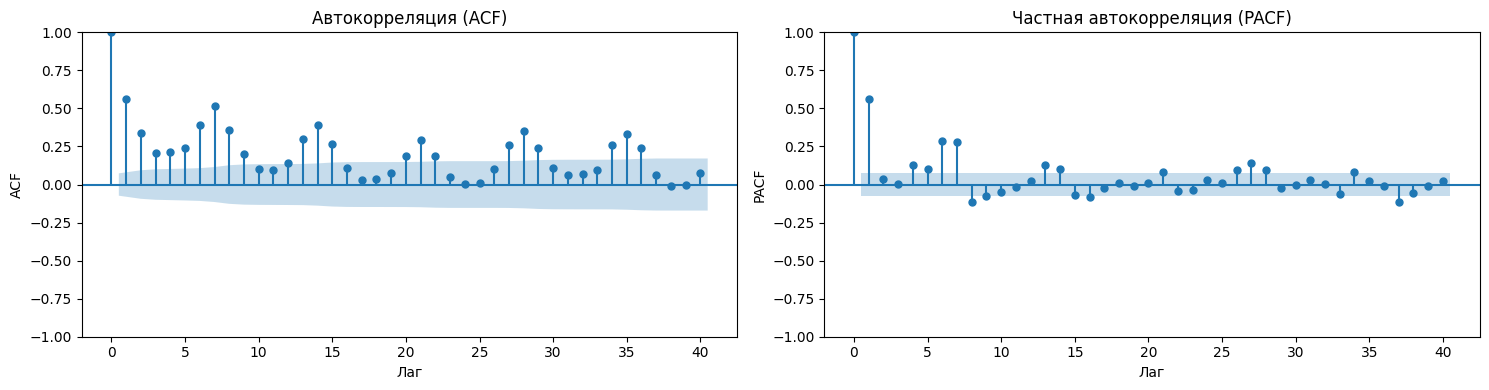

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

plot_acf(train_data[train_data['id'] == 92]['value'], lags=40, ax=ax[0], title='Автокорреляция (ACF)')
ax[0].set_xlabel('Лаг')
ax[0].set_ylabel('ACF')

plot_pacf(train_data[train_data['id'] == 92]['value'], lags=40, ax=ax[1], title='Частная автокорреляция (PACF)')
ax[1].set_xlabel('Лаг')
ax[1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

__Ответьте на следующие вопросы:__
- Стационарен ли временной ряд? Нет, ряд имеет значимые автокорреляции на большом числе лагов (после 1-2)
- Присутствует ли в нём тренд? Сезонность? Цикличность? Сезонность точно, тк наблюдаются пики acf каждые 7 лагов, у pacf тоже есть сезонность. для acf отсутствие медленного затухания корреляции на больших лагах, скорее всего тренда нет

- Если ряд сезонный, то какой период выглядит наиболее вероятным? 7 дней (неделя)

#### Задание 2.2: Построение модели SARIMA (2 балла)

Пользуясь правилами отсюда: https://people.duke.edu/~rnau/arimrule.html, попробуйте подобрать параметры SARIMA модели, как мы делали это на семинаре.

Не забудьте о возможности использовать предобработку данных, например, логарифмирование и удаление выбросов (самое простое — это воспользоваться IQR: https://medium.com/@divyansh9144/iqr-interquartile-range-for-anomaly-detection-f9c568d1195f).

Если вы используете предобработку, то обязательно укажите, какую именно и почему.

логарифмирование не нужно тк оно обычно используется при наличии экспоненциального роста, а также если сезонность мультипликативная

- По первому правилу, если ряд имеет положительные автокорреляции до большого числа лагов, то, вероятно, требуется более высокий порядок дифференцирования.
- По двенадцатому правилу, если ряд имеет ярко выраженный и устойчивый сезонный паттерн, то необходимо использовать порядок сезонного дифференцирования.

In [62]:
series_92 = train_data[train_data['id'] == 92]
# Q1 = series_92['value'].quantile(0.25)
# Q3 = series_92['value'].quantile(0.75)
# IQR = Q3 - Q1
series_92_clean = series_92
# series_92_clean = series_92[(series_92['value'] >= Q1 - 1.5*IQR) & (series_92['value'] <= Q3 + 1.5*IQR)]

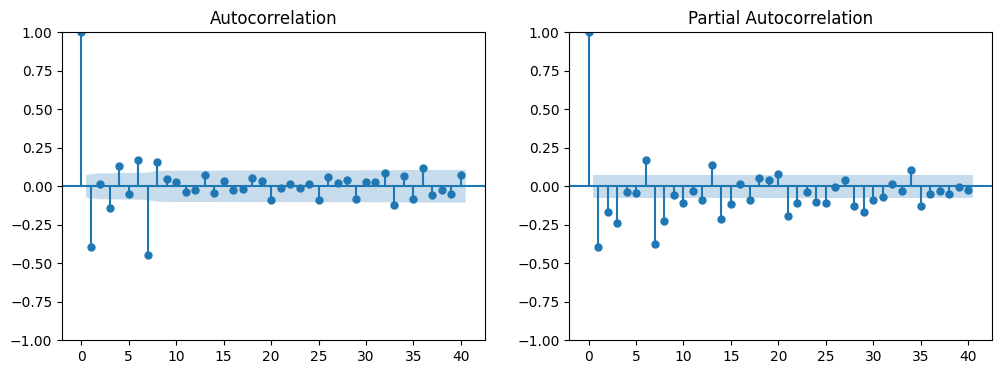

In [63]:
# ACF и PACF после сезонного и обычного дифференцирования
diff_seas_series = series_92_clean['value'].diff(7).dropna()
diff__diff_series = diff_seas_series.diff().dropna()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(diff__diff_series, lags=40, ax=ax[0])
plot_pacf(diff__diff_series, lags=40, ax=ax[1])
plt.show()

- По седьмому правилу, лаг, после которого ACF обрывается, указывает на требуемое количество MA членов.
- По тренадцатому правилу, если автокорреляция дифференцированного ряда отрицательна на лаге s, то надо добавить SMA член в модель.
Очень похоже на ситуацию на семинаре

                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                  712
Model:             SARIMAX(0, 1, 2)x(1, 1, 2, 7)   Log Likelihood               -2182.470
Date:                           Fri, 23 May 2025   AIC                           4376.940
Time:                                   12:39:17   BIC                           4404.134
Sample:                                        0   HQIC                          4387.461
                                           - 712                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6078      0.023    -26.314      0.000      -0.653      -0.563
ma.L2         -0.1481      0.028     -5.260

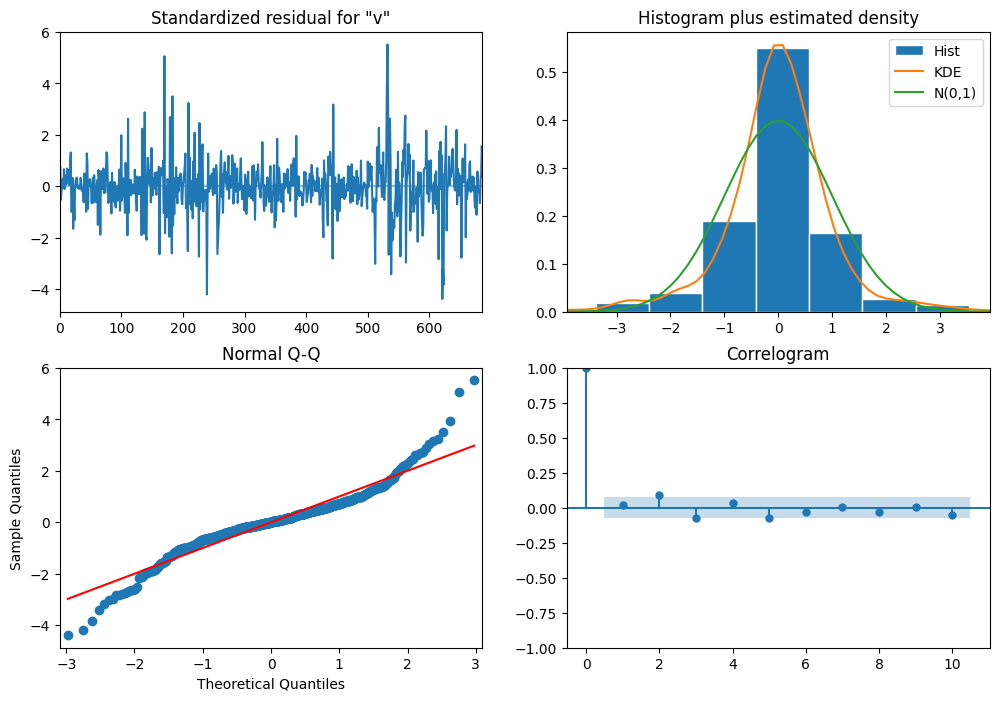

In [70]:
model = SARIMAX(
    series_92_clean["value"],
    order=(0, 1, 2),
    seasonal_order=(1, 1, 2, 7),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
model_fit = model.fit(disp=False)
print(model_fit.summary())

model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

#### Задание 2.3: Анализ остатков (0.5 баллов)

Постройте графики ACF и PACF остатков модели SARIMA. Проверьте, что в остатках нет значимых автокорреляций. Если они есть, то попробуйте объяснить, почему это происходит.

Проведите тест на стационарность остатков модели. Проведите тест на автокорреляцию остатков модели. Проинтерпретируйте результаты тестов. Если тесты показывают, что остатки нестационарны или в них есть автокорреляция, то попробуйте объяснить, почему это происходит.

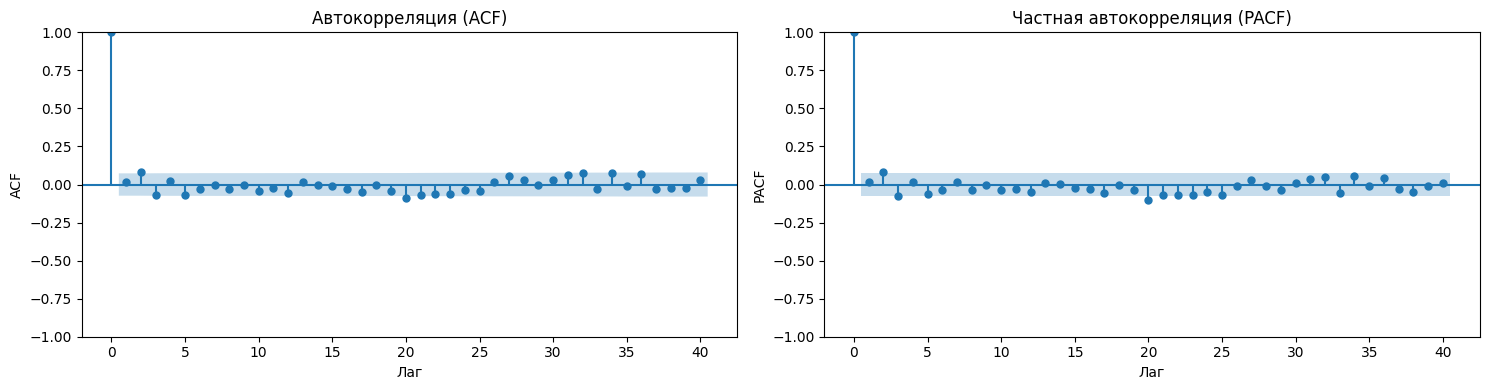

In [71]:
residuals = model_fit.resid

fig, ax = plt.subplots(1, 2, figsize=(15, 4))

plot_acf(residuals, lags=40, ax=ax[0], title='Автокорреляция (ACF)')
ax[0].set_xlabel('Лаг')
ax[0].set_ylabel('ACF')

plot_pacf(residuals , lags=40, ax=ax[1], title='Частная автокорреляция (PACF)')
ax[1].set_xlabel('Лаг')
ax[1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

пик на 1 лаге значит показывает, что существует автокорреляция между остатками и их первым лагом, нужно либо добавить AR часть, либо добавить дифференцирование

In [72]:
# H0: остатки стационарны
statistic, p_value, lags, critical_values = kpss(residuals)
print(f"KPSS p-value: {p_value}")

# H0: остатки не стационарны
statistic, p_value, usedlag, _, critical_values, icbest = adfuller(residuals)
print(f"ADF p-value: {p_value}")

# H0: автокорреляция отсутствует
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb_test)

KPSS p-value: 0.1
ADF p-value: 2.8298152347653304e-28
      lb_stat  lb_pvalue
10  15.432885   0.117059


по обоим тестам ряд стационарен, но автокорреляция значима

в итоге перебрала (0, 1, 1)x(0, 1, 1, 12), (1, 1, 1)x(0, 1, 1, 12),  (0, 1, 1)x(1, 1, 2, 7), (0, 1, 2)x(1, 1, 2, 7), (0, 2, 2)x(1, 1, 2, 7), (1, 2, 2)x(1, 1, 2, 7)

лучшей по AIC BIC оказалась (0, 1, 2)x(1, 1, 2, 7), хотя по графику должно быть 2 MA части, ее и оставим

по итогу после графика предсказаний я решила не удалять выбросы, тогда автокорреляция оказалась не значимой

#### Задание 2.4: Получение прогнозов и выводы (1 балл)

С помощью полученной модели постройте прогноз на тестовую выборку.

Постройте график прогноза и фактических значений. Сделайте выводы о том, насколько хорошо модель предсказывает временной ряд.

Посчитайте метрику MASE, которую мы имплементировали в начале ноутбука. Объясните, что она показывает и почему ее потенциально полезнее использовать для сравнения моделей, чем MAE или MAPE. Выводы по самому значению метрики делать не нужно.

In [67]:
import plotly.graph_objects as go

series_92_train = train_data[train_data['id'] == 92]
series_92_test = test_data[test_data['id'] == 92]

forecast = model_fit.get_forecast(steps=len(series_92_test))
predictions = forecast.predicted_mean

predictions_df = pd.DataFrame({
    "date": series_92_test["date"].values,
    "value": predictions.values
})

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=series_92_train["date"], y=series_92_train["value"],
               name="Train (id=92)", line=dict(color="blue"))
)
fig.add_trace(
    go.Scatter(x=series_92_test["date"], y=series_92_test["value"],
               name="Test (id=92)", line=dict(color="red"))
)
fig.add_trace(
    go.Scatter(
        x=predictions_df["date"],
        y=predictions_df["value"],
        name="Predictions (id=92)",
        line=dict(color="green", dash="dot")
    )
)
fig.update_layout(
    title="Прогноз SARIMA для временного ряда (id=92)",
    xaxis_title="Дата",
    yaxis_title="Значение",
    hovermode="x unified"
)
fig.show()

In [68]:
forecast = model_fit.get_forecast(steps=len(series_92_test))
predictions = forecast.predicted_mean

frequency = 7
mase_value = mase(
    forecast=predictions.values,
    insample=series_92_clean["value"].values,
    outsample=series_92_test["value"].values,
    frequency=frequency)
mase_value

np.float64(1.2101781367712863)

По итогу с удалением выбросов медель имела очень маленькую диспресию и плохо предсказывала, я убрала выбросы и стало лучше, mase уменьшилась с 1.60 до 1.21

мне кажется странно удалять выбросы учитывая структуру временного ряда, он просто не будет предсказывать высокие/низкие пики

### Задание 3. Построение бейзлайнов на всех рядах и автоматический подбор параметров (2 балла)

#### Задание 3.1: Запуск бейзлайнов (1 балл)
Давайте будем использовать statsforecast для бейзлайнов, так же как мы делали это на семинаре: https://nixtlaverse.nixtla.io/statsforecast/index.html

Постройте прогнозы на всех рядах с помощью следующих бейзлайнов:
- Naive
- Seasonal Naive
- AutoARIMA
- еще 2 на ваш выбор (например, ETS, Theta, TBATS или другие, которые вам нравятся). Кратко опишите суть выбранных моделей.

In [78]:
from statsforecast.models import Naive, SeasonalNaive, AutoARIMA, Theta, AutoETS

In [84]:
models = [
    Naive(),
    SeasonalNaive(season_length=7),
    AutoARIMA(season_length=7),
    Theta(),
    AutoETS(season_length=7)
]

train_df = train_data.rename(columns={
    'id': 'unique_id',
    'value': 'y',
    'date': 'ds'
}).sort_values(['unique_id', 'ds'])

test_df = test_data.rename(columns={
    'id': 'unique_id',
    'value': 'y',
    'date': 'ds'
})

sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1,
    fallback_model=Naive()
)

sf = StatsForecast(models=models, freq='D', n_jobs=-1)

forecast_df = sf.forecast(df=train_df, h=HORIZON)
forecast_df.head()

unique_id         ds      Naive  SeasonalNaive  AutoARIMA      Theta  \
0          0 1998-02-28  45.493197      30.938209  29.981684  38.722924   
1          0 1998-03-01  45.493197      25.864512  27.448830  38.733584   
2          0 1998-03-02  45.493197      21.230159  23.786024  38.744245   
3          0 1998-03-03  45.493197      29.733560  32.328147  38.754905   
4          0 1998-03-04  45.493197      42.871315  39.473895  38.765566   

     AutoETS  
0  29.783976  
1  28.656243  
2  25.436134  
3  33.247674  
4  39.792045

#### Задание 3.2: Анализ результатов (1 балл)

Постройте графики фактических значений и прогнозов для всех бейзлайнов для ряда 92. Выведите метрики MASE.

Что можно сказать о каждом из бейзлайнов? Какой из бейзлайнов лучше всего предсказывает временной ряд?

Смогли ли вы руками подобрать гиперпараметры для SARIMA модели лучше, чем автоматический подбор в библиотеке? Если да, то вы огромный молодец! Если нет, то не расстраивайтесь, так бывает.

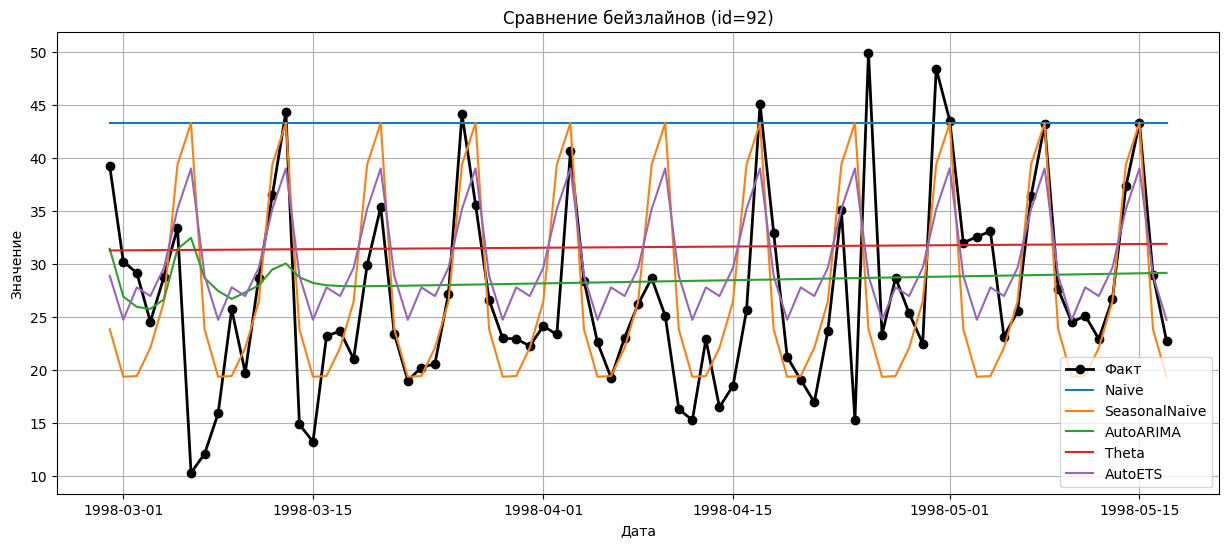

In [86]:
forecast_92 = forecast_df[forecast_df['unique_id'] == 92]

y_test_92 = test_data[test_data['id'] == 92].sort_values('date')['value'].values
dates_test_92 = test_data[test_data['id'] == 92].sort_values('date')['date'].values

plt.figure(figsize=(15, 6))
plt.plot(dates_test_92, y_test_92, label='Факт', marker='o', linewidth=2, color='black')

model_columns = [col for col in forecast_92.columns if col not in ['ds', 'unique_id']]
for model in model_columns:
    plt.plot(dates_test_92, forecast_92[model].values, label=model)

plt.title('Сравнение бейзлайнов (id=92)')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()


Постройте датафрейм с MASE для всех бейзлайнов (агрегированный по всем рядам). Какой из бейзлайнов лучше всего предсказывает временные ряды в нашем датасете? Какой из бейзлайнов хуже всего предсказывает временные ряды в нашем датасете? Как вы думаете, почему так происходит?

In [88]:
insample_92 = train_data[train_data['id'] == 92].sort_values('date')['value'].values
for model in model_columns:
    forecast_model = forecast_92[model].values
    mase_score = mase(forecast_model, insample_92, y_test_92, 1)
    print(f"{model}: MASE = {mase_score:.3f}")

Naive: MASE = 3.108
SeasonalNaive: MASE = 1.079
AutoARIMA: MASE = 1.329
Theta: MASE = 1.592
AutoETS: MASE = 1.124


naive, theta и autoARIMA и theta почему-то предсказывают константы или почти константы. наивная модель не улавливают колебаний и просто повторяют последнее значение, поэтому и константа, а с аримой и тетой не так очевидно, почему. лучшим оказался наивный сезонный прогноз

с аримой можно было бы предположить что модель просто всеми силами уменьшает ошибку, не смотря на адекватность, но ручной подбор получился лучше, так что не понятно

Постройте графики фактических значений и прогнозов самого сильного бейзлайна для еще 3-х каких-нибудь рядов и ответьте на следующие вопросы:
- Есть ли среди них такие, которые предсказываются хуже остальных?
- Есть ли среди них такие, которые предсказываются лучше остальных?

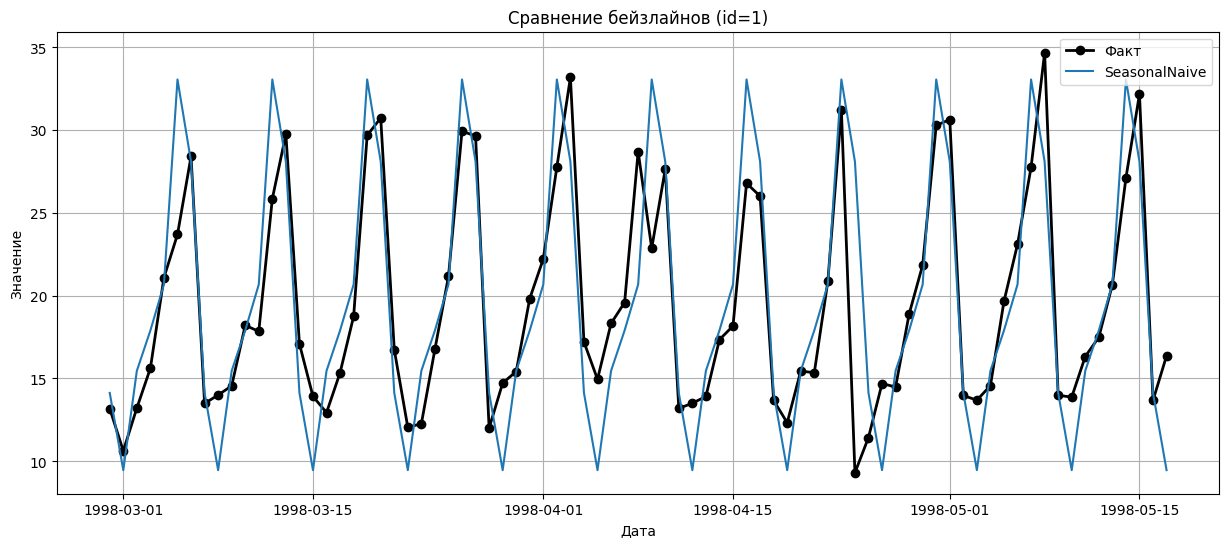

In [91]:
forecast_92 = forecast_df[forecast_df['unique_id'] == 1]

y_test_92 = test_data[test_data['id'] == 1].sort_values('date')['value'].values
dates_test_92 = test_data[test_data['id'] == 1].sort_values('date')['date'].values

plt.figure(figsize=(15, 6))
plt.plot(dates_test_92, y_test_92, label='Факт', marker='o', linewidth=2, color='black')

plt.plot(dates_test_92, forecast_92['SeasonalNaive'].values, label='SeasonalNaive')

plt.title('Сравнение бейзлайнов (id=1)')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

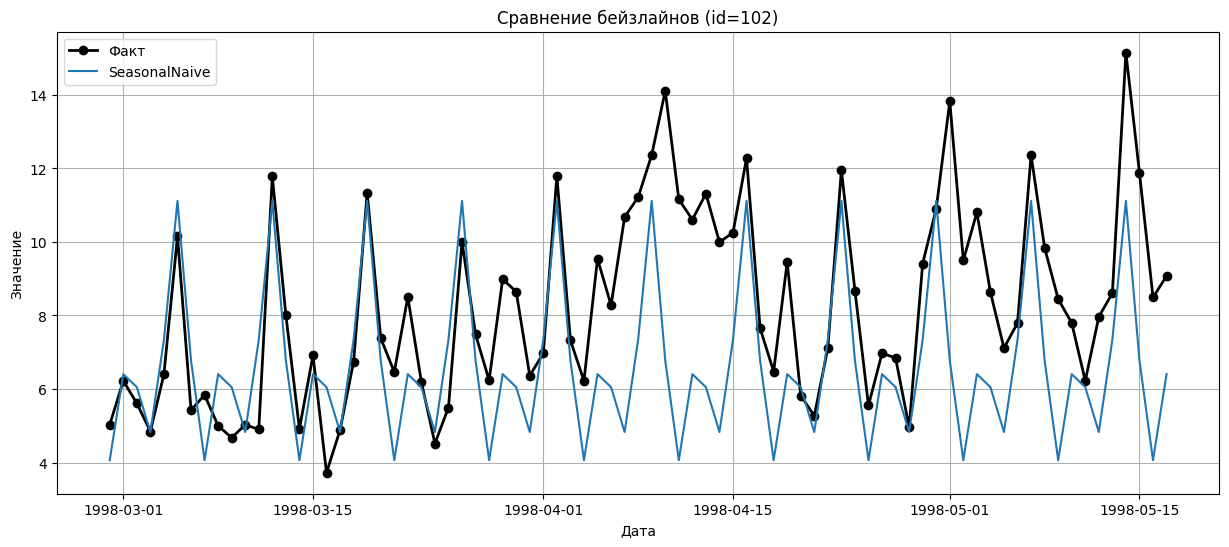

In [93]:
forecast_92 = forecast_df[forecast_df['unique_id'] == 102]

y_test_92 = test_data[test_data['id'] == 102].sort_values('date')['value'].values
dates_test_92 = test_data[test_data['id'] == 102].sort_values('date')['date'].values

plt.figure(figsize=(15, 6))
plt.plot(dates_test_92, y_test_92, label='Факт', marker='o', linewidth=2, color='black')

plt.plot(dates_test_92, forecast_92['SeasonalNaive'].values, label='SeasonalNaive')

plt.title('Сравнение бейзлайнов (id=102)')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

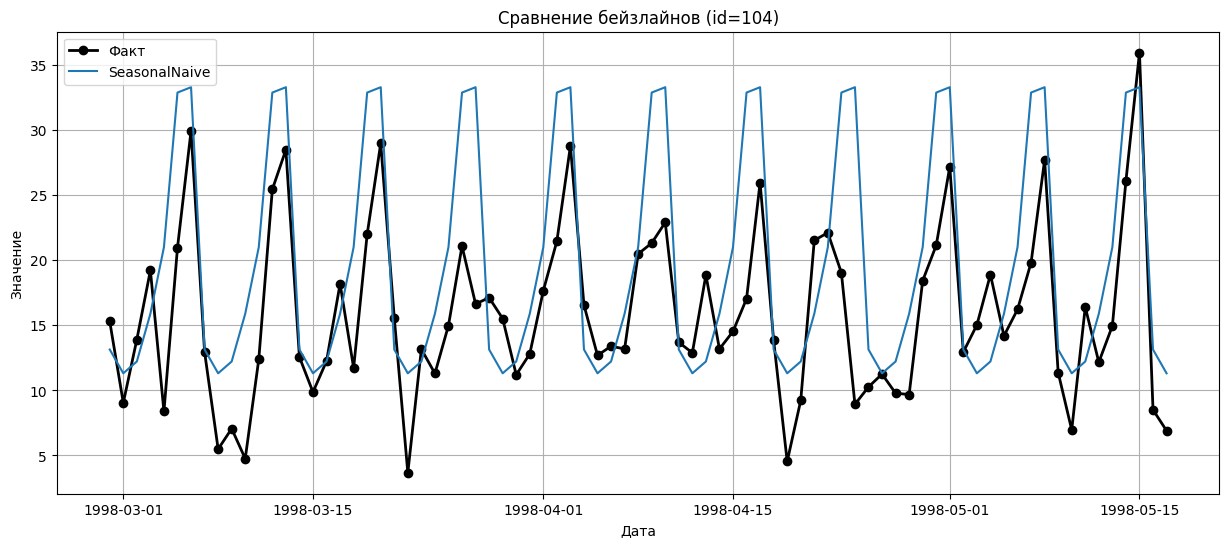

In [92]:
forecast_92 = forecast_df[forecast_df['unique_id'] == 104]

y_test_92 = test_data[test_data['id'] == 104].sort_values('date')['value'].values
dates_test_92 = test_data[test_data['id'] == 104].sort_values('date')['date'].values

plt.figure(figsize=(15, 6))
plt.plot(dates_test_92, y_test_92, label='Факт', marker='o', linewidth=2, color='black')

plt.plot(dates_test_92, forecast_92['SeasonalNaive'].values, label='SeasonalNaive')

plt.title('Сравнение бейзлайнов (id=104)')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

SeasonalNaive просто повторяет колебания с лагом -длина сезонности, поэтому эта модель плохо подходит для более сложных рядов и это видно на графике

### Задание 4. ML & DL модели (3 балла)

Здесь хочется дать вам полную свободу действий.

Вам нужно будет выбрать одну из ML моделей и одну из DL моделей (старайтесь не повторять один в один решение из семинара, а, если повторяете, то попробуйте, например, перебрать параметры DL модели, оптимизации, препроцессинга / добавить экзогенные признаки (актуально для MIMO стратегии) и т. д.) и построить прогнозы для всех временных рядов на тестовой выборке. __Ваша цель (желательная, но необязательная) — улучшить MASE, полученный с помощью бейзлайнов.__

__Результат задания — мини-отчет по тому, что вы попробовали, что получилось и что не получилось.__ По одному баллу дается за работу с данными (предобработка, генерация дополнительных признаков), за применение ML и DL моделей и интерпретацию полученных с помощью них результатов. Не забудьте кратко описать суть выбранных моделей (особенно, если речь идет о DL моделях).

Вы можете использовать любые модели и библиотеки (`tsfresh` для извлечения признаков, `Tsururu` / `ETNA` / `darts` для использования предобработки, стратегий, моделей и т. д.).

In [12]:
df['weekday'] = df['date'].dt.weekday
df['month'] = df['date'].dt.month

for lag in [1, 2, 3]:
    df[f'lag_{lag}'] = df.groupby('id')['value'].shift(lag)

df['rolling_mean_3'] = df.groupby('id')['value'].transform(lambda x: x.rolling(3).mean())

df = df.dropna().reset_index(drop=True)

In [13]:
test_size = 0.1
unique_dates = df['date'].sort_values().unique()
HORIZON = int(len(unique_dates) * test_size)
split_date = unique_dates[-HORIZON]

train = df[df['date'] < split_date]
test = df[df['date'] >= split_date]

In [14]:
features = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'weekday', 'month']
X_train = train[features]
y_train = train['value']
X_test = test[features]
y_test = test['value']

In [12]:
!pip install catboost
from catboost import CatBoostRegressor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.8 MB/s eta 0:00:00


In [14]:
cat_features = ['weekday', 'month']

model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    loss_function='MAE',
    random_seed=42,
    early_stopping_rounds=30,
    verbose=50
)

model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    use_best_model=True
)


0:	learn: 6.9312351	test: 7.5243337	best: 7.5243337 (0)	total: 211ms	remaining: 1m 45s
50:	learn: 2.8679568	test: 3.1472037	best: 3.1472037 (50)	total: 8.19s	remaining: 1m 12s
100:	learn: 2.1072799	test: 2.3202340	best: 2.3202340 (100)	total: 14.6s	remaining: 57.8s
150:	learn: 1.6763855	test: 1.8750982	best: 1.8750982 (150)	total: 21.6s	remaining: 50s
200:	learn: 1.3793144	test: 1.5801313	best: 1.5801313 (200)	total: 26.7s	remaining: 39.7s
250:	learn: 1.1682722	test: 1.3612019	best: 1.3612019 (250)	total: 29.4s	remaining: 29.2s
300:	learn: 1.0139388	test: 1.2021419	best: 1.2021419 (300)	total: 32.4s	remaining: 21.4s
350:	learn: 0.8932787	test: 1.0763000	best: 1.0763000 (350)	total: 38.6s	remaining: 16.4s
400:	learn: 0.7973000	test: 0.9650003	best: 0.9650003 (400)	total: 43.9s	remaining: 10.8s
450:	learn: 0.7212713	test: 0.8790812	best: 0.8790812 (450)	total: 51.9s	remaining: 5.64s
499:	learn: 0.6545099	test: 0.7958604	best: 0.7958604 (499)	total: 55.8s	remaining: 0us

bestTest = 0.7958

In [15]:
y_pred = model.predict(X_test)

In [16]:
frequency = 7

mase_score = mase(
    forecast=y_pred,
    insample=y_train.values,
    outsample=y_test.values,
    frequency=frequency
)
print(f"CatBoost MASE: {mase_score:.4f}")

CatBoost MASE: 0.1786


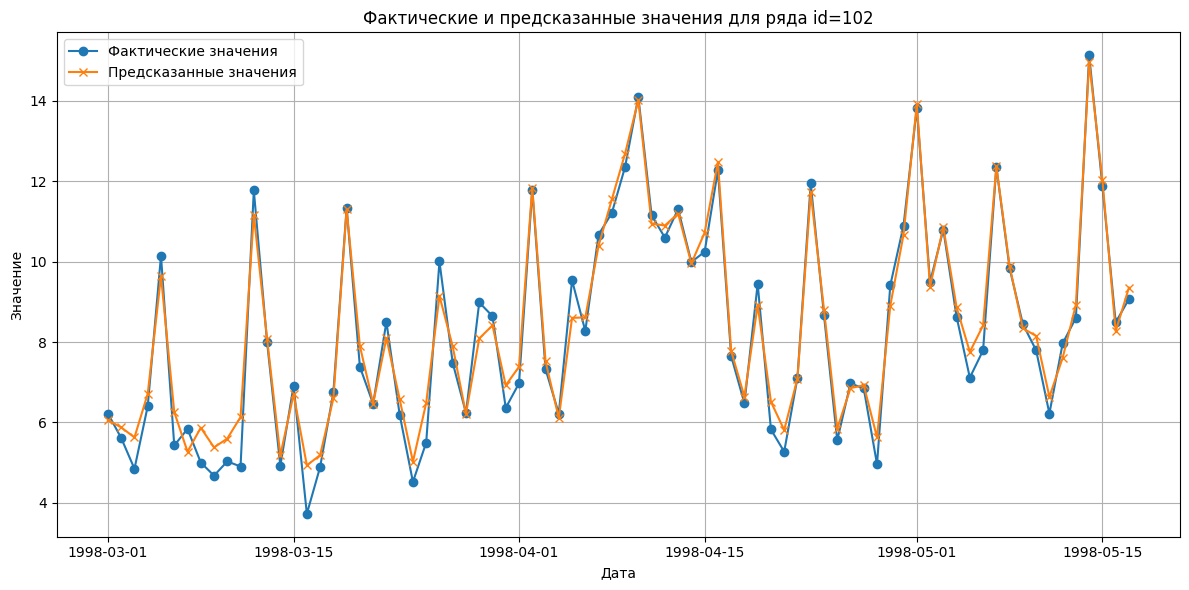

In [19]:
import matplotlib.pyplot as plt

mask_102 = test['id'] == 102
dates_102 = test.loc[mask_102, 'date']
y_test_102 = y_test[mask_102]
y_pred_102 = y_pred[mask_102]

plt.figure(figsize=(12, 6))
plt.plot(dates_102, y_test_102, label='Фактические значения', marker='o')
plt.plot(dates_102, y_pred_102, label='Предсказанные значения', marker='x')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Фактические и предсказанные значения для ряда id=102')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

catboost уже давно нам знаком, даже не перебирая параметры получилось выбить качество сильно лучше, чем при использовании бейзлайнов, по графику также видно, что предсказание достаточно точное

в качестве DL метода будем использовать lstm, попробуем еще увеличить количество признаков

In [15]:
df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

df[f'lag_7'] = df.groupby('id')['value'].shift(7)

for window in [3, 7]:
    df[f'roll_mean_{window}'] = df.groupby('id')['value'].transform(lambda x: x.rolling(window).mean())
    df[f'roll_std_{window}'] = df.groupby('id')['value'].transform(lambda x: x.rolling(window).std())
    df[f'roll_median_{window}'] = df.groupby('id')['value'].transform(lambda x: x.rolling(window).median())

df['diff_lag_1'] = df['value'] - df['lag_1']

df = df.dropna().reset_index(drop=True)

lstm ожидает входы в формате [samples, timesteps, features], для каждого ряда будем формировать последовательности фиксированной длины (window_size).

In [16]:
from sklearn.preprocessing import MinMaxScaler

window_size = 10
feature_cols = [
    'value', 'lag_1', 'lag_2', 'lag_3', 'lag_7',
    'roll_mean_3', 'roll_mean_7', 'roll_std_3', 'roll_std_7',
    'roll_median_3', 'roll_median_7', 'diff_lag_1',
    'weekday', 'month', 'is_month_start', 'is_weekend'
]

all_X, all_y = [], []
for series_id in df['id'].unique():
    df_id = df[df['id'] == series_id].copy()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_id[feature_cols])
    for i in range(window_size, len(df_id)):
        all_X.append(scaled[i-window_size:i])
        all_y.append(df_id['value'].iloc[i])

X = np.array(all_X)
y = np.array(all_y)

In [17]:
dates = df[df['id'] == df['id'].unique()[0]]['date'].iloc[window_size:]
HORIZON = int(len(dates) * 0.1)
split_idx = len(X) - HORIZON

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [20]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch

In [24]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [22]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out.squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size=X.shape[2]).to(device)

In [26]:
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader.dataset):.4f}")

Epoch 1/10, Loss: 5.3048
Epoch 2/10, Loss: 5.2471
Epoch 3/10, Loss: 5.2003
Epoch 4/10, Loss: 5.1443
Epoch 5/10, Loss: 5.0737
Epoch 6/10, Loss: 5.0101
Epoch 7/10, Loss: 4.9355
Epoch 8/10, Loss: 4.8744
Epoch 9/10, Loss: 4.8156
Epoch 10/10, Loss: 4.7606


In [28]:
model.eval()
preds = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch)
        preds.append(output.cpu().numpy())
y_pred = np.concatenate(preds)

In [33]:
frequency = 7
mase = mase(
    forecast=y_pred,
    insample=y_train,
    outsample=y_test,
    frequency=frequency
)

print(f"MASE: {mase:.4f}")

MASE: 0.6006


получилось хуже, чем у catboost